<a href="https://colab.research.google.com/github/JEduardoDimasR/Proyecto-personal/blob/main/Pron%C3%B3stico_de_transacciones_en_una_cadena_de_tiendas_minoristas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar librerías

In [60]:
import warnings

# Ignorar todas las advertencias
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import GRU, Dense

## Cargar datos

In [25]:
store_df = pd.read_excel("store.xls")

## Comprender la información de los datos

In [26]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          115 non-null    datetime64[ns]
 1   Transactions  115 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 KB


In [27]:
store_df.shape

(115, 2)

Se cuenta con un conjunto de datos de 115 observaciones y 2 variables, una de tipo númerica y otra de tipo temporal.


In [28]:
store_df.set_index(pd.to_datetime(store_df.Date),inplace=True)
store_df.drop("Date", axis = 1, inplace = True)
store_df[-5:]

,Transactions
Date,
2015-01-19,18
2015-01-20,22
2015-01-21,22
2015-01-22,21
2015-01-23,17


## Visualizar la serie de tiempo

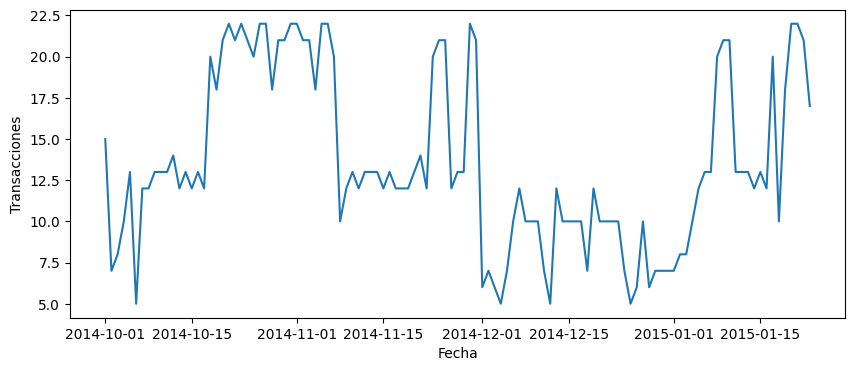

In [29]:
plt.figure( figsize=(10,4))
plt.xlabel( "Fecha" )
plt.ylabel( "Transacciones" )
plt.plot( store_df.Transactions )

La serie presenta varias fluctuaciones, lo cuál muestra que es necesario visualizar de manera mas detallada sus componentes.

## Descomposición de la serie de tiempo en sus componentes

Para descomponer la serie de tiempo en sus componentes, se utilizara el modelo multiplicativo, el cuál viene dado por:

$$Y_t=T_t*S_t*C_t*I_t$$

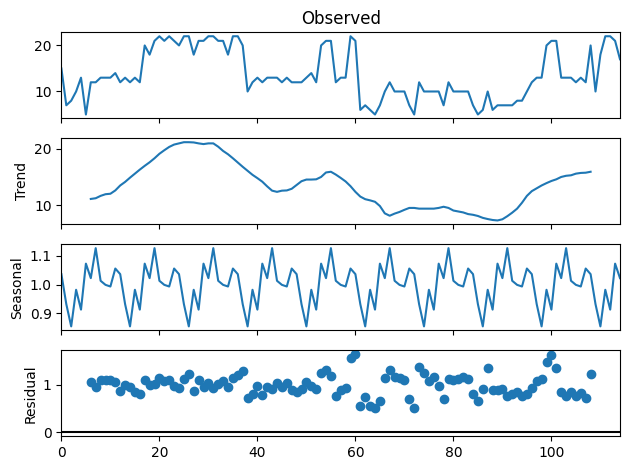

In [33]:
ts_decompose = seasonal_decompose(np.array(store_df["Transactions"]), model="multiplicative", period = 12)
## Plotting the deocomposed time series components
ts_plot = ts_decompose.plot()

Los residuales no se alcanzan a visualizar de manera adecuada, por lo que es necesario graficarlos por separado.

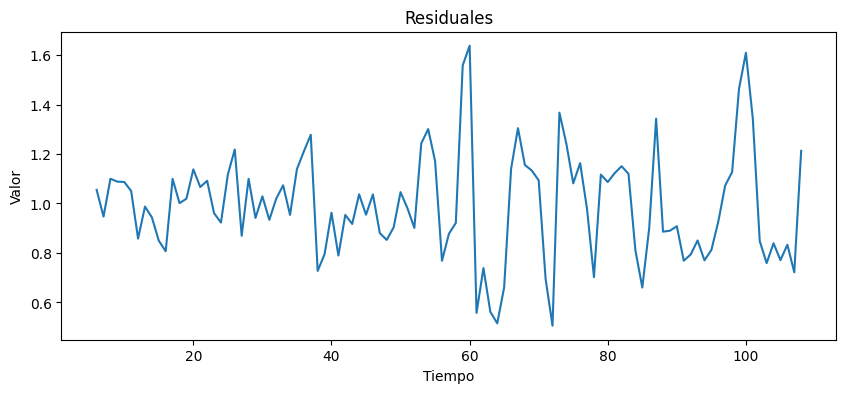

In [36]:
ts_decompose = seasonal_decompose(np.array(store_df["Transactions"]), model="multiplicative", period = 12)

# Obteniendo los residuos
residuals = pd.Series(ts_decompose.resid)

# Creando un gráfico de los residuos sin puntos
plt.figure(figsize=(10, 4))
plt.plot(residuals.index, residuals.values, linestyle='-', marker='')  # Configurando el marcador como vacío para eliminar puntos
plt.title('Residuales')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.show()

Como se muestra, el modelo está capturando adecuadamente la variabilidad en los datos. Además, la tendencia muestra declives la mayor parte del tiempo.

## Condiciones para la estacionariedad en datos de series temporales

Los datos de series temporales deben cumplir con las siguientes condiciones para ser estacionarios:

1. Los valores medios de $Y_t$ en diferentes valores de $t$ son constantes.
2. Las varianzas de $Y_t$ en diferentes períodos de tiempo son constantes (Homocedasticidad).
3. La covarianza de $Y_t$ y $Y_{t−k}$ para diferentes rezagos depende solo de $k$ y no del tiempo $t$.

### Autocorrelación de los datos (ACF)

Una de las formas más fáciles de observar si una serie es estacionaria o no es mediante el gráfico ACF. Si existe una disminución lenta de las autocorrelaciones para diferentes rezagos, indica que la serie no es estacionaria.

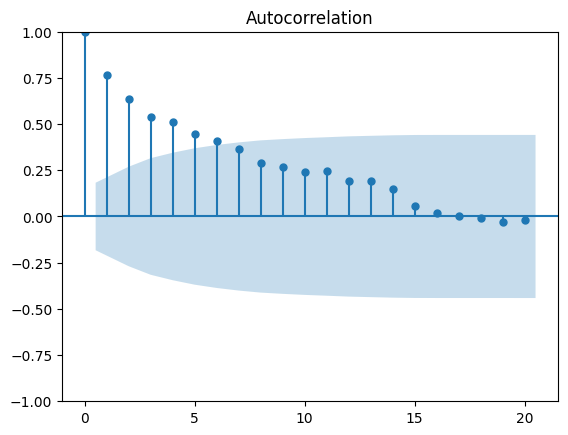

In [40]:
acf_plot = plot_acf( store_df.Transactions,lags=20 )

La lenta disminución de las autocorrelaciones para diferentes rezagos indica que la serie no es estacionaria.

### Prueba de Dickey-Fuller

Para determinar si una serie temporal es estacionaria, también se puede realizar el test de Dickey-Fuller. El test de Dickey-Fuller verifica si el valor de ($\beta$) de un modelo ARIMA es igual a 1 o menor o igual a 1. Es un test de hipótesis en el que la hipótesis nula y la hipótesis alternativa se plantean de la siguiente manera:

- $H_0$: $\beta$ = 1 (la serie temporal no es estacionaria).

- $H_A$: $\beta < 1$ (la serie temporal es estacionaria).

Otra manera de verificar la estacionariedad es mediante el p-value. Si este es menor a 0.05, se rechaza la hipótesis nula y se concluye que la serie es estacionaria.

In [42]:
def adfuller_test( ts ):
  adfuller_result = adfuller( ts, autolag=None )
  adfuller_out = pd.Series(adfuller_result[0:4],
  index=['Test Statistic',
  'p-value',
  'Lags Used',
  'Number of Observations Used'])
  print( adfuller_out )

adfuller_test(store_df.Transactions)

Test Statistic                  -1.649533
p-value                          0.457284
Lags Used                       13.000000
Number of Observations Used    101.000000
dtype: float64


Ya que el p-value es mayor a 0.05, se concluye que la serie no es estacionaria.

### Diferenciar la serie

Una de las formas más comunes de volver estacionaria una serie de tiempo es mediante la diferenciación. Por ejemplo, la primer diferencia $(d=1)$ se define como:

$$\Delta Y_t= Y_t-Y_{t-1}$$

In [47]:
store_df["Tran_diff"] = store_df.Transactions - store_df.Transactions.shift(1)
store_df.head(5)

,Transactions,Tran_diff
Date,,
2014-10-01,15,NaN
2014-10-02,7,-8.0
2014-10-03,8,1.0
2014-10-04,10,2.0
2014-10-05,13,3.0


In [49]:
Tran_diff_df = store_df.dropna()

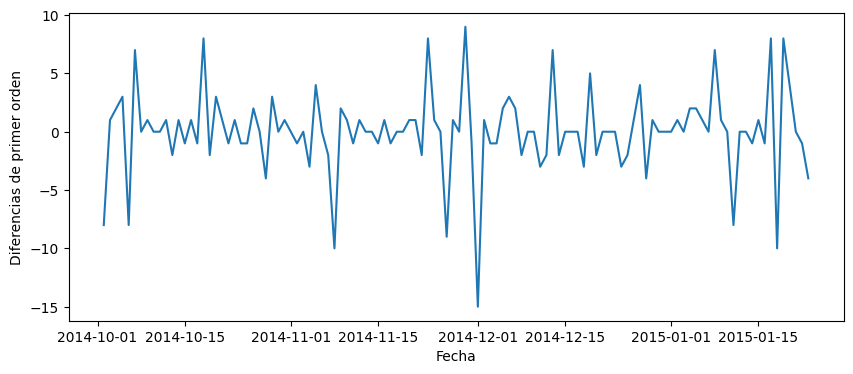

In [50]:
plt.figure(figsize=(10,4))
plt.xlabel("Fecha")
plt.ylabel("Diferencias de primer orden")
plt.plot( Tran_diff_df.Tran_diff);

La serie indica la tendencia de primer orden de las diferencias de demanda a lo largo de las fechas. De nuevo, no es muy visible si la serie es estacionaria o no. Necesitaremos trazar el gráfico ACF para verificarlo.

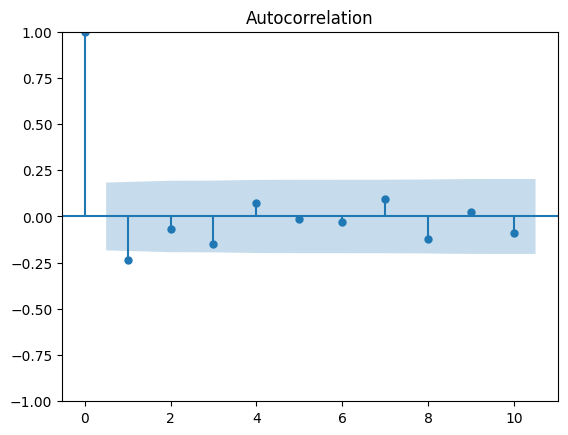

In [53]:
pacf_plot = plot_acf(store_df.Tran_diff.dropna(),lags=10)

El gráfico ACF de la serie (d=1) no muestra signos de una reducción lenta de la autocorrelación a lo largo de los rezagos; corta inmediatamente a cero. Además, existe autocorrelación para el primer rezago, lo cual es útil para crear el modelo ARIMA que se presenta a continuación.

## Modelo ARIMA

Los modelos ARMA se pueden utilizar solo cuando los datos de series temporales son estacionarios. Los modelos ARIMA se utilizan cuando los datos de series temporales no son estacionarios. Se considera que los datos de series temporales son estacionarios si la media, la varianza y la covarianza se mantienen constantes a lo largo del tiempo. ARIMA tiene los siguientes tres componentes y se representa como $ARIMA (p, d, q)$:

- Componente AR con p rezagos $AR(p)$.
- Componente de integración, $I(d)$.
- Componente MA con q rezagos, $MA(q)$.

El objetivo principal del componente de integración es convertir un proceso de series de tiempo no estacionario en un proceso estacionario para que los procesos AR y MA puedan usarse para realizar pronósticos.

Como se mencionó anteriormente, el modelo adecuado para pronosticar el número de transacciones en una cadena de tiendas, según la autocorrelación para el primer rezago y la primera diferenciación, sería $ARIMA(1,1,1)$.

### Elección de tamaño para la división de datos de entrenamiento y prueba

Para elegir la proporción de datos de entrenamiento y prueba, a menudo se selecciona el 80% y el 20%, o el 70% y el 30%, respectivamente. Esta elección puede ser beneficiosa si el conjunto de datos original es lo suficientemente grande como para que la información valiosa necesaria para crear el modelo ARIMA esté capturada en el conjunto de entrenamiento. Sin embargo, debido a esta limitación, es necesario llevar a cabo una prueba utilizando una métrica de utilidad. En este caso, se utilizará el error porcentual absoluto medio (MAPE), con el objetivo de seleccionar el tamaño óptimo de los datos para el cual el MAPE sea mínimo en el conjunto de datos.

In [61]:
from statsmodels.tsa.arima.model import ARIMA as arima_model  # Importar ARIMA desde el nuevo módulo

# Función para evaluar el modelo ARIMA con diferentes tamaños de datos de entrenamiento
def evaluar_arima_con_diferentes_tamanos(datos, tamano_maximo_entrenamiento):
    mape_minimo = float('inf')  # Valor infinito para encontrar el mínimo
    mejor_tamano_entrenamiento = None

    for tamano_entrenamiento in range(10, tamano_maximo_entrenamiento + 1):
        # Dividir los datos en conjunto de entrenamiento y prueba
        datos_entrenamiento = datos[:tamano_entrenamiento]
        datos_prueba = datos[tamano_entrenamiento:]

        # Entrenar modelo ARIMA
        modelo = arima_model(datos_entrenamiento, order=(1, 1, 1))  # Añadir 'endog' como la serie temporal
        modelo_entrenado = modelo.fit()

        # Realizar predicciones
        predicciones = modelo_entrenado.predict(start=len(datos_entrenamiento), end=len(datos) - 1)

        # Calcular MAPE
        mape = mean_absolute_percentage_error(datos_prueba, predicciones)

        # Verificar si este MAPE es el mínimo hasta ahora
        if mape < mape_minimo:
            mape_minimo = mape
            mejor_tamano_entrenamiento = tamano_entrenamiento

    return mejor_tamano_entrenamiento, mape_minimo

# Suponiendo que 'store_df.Transactions' es tu serie temporal
# Llamada a la función para evaluar el modelo ARIMA con diferentes tamaños de datos de entrenamiento
mejor_tamano, mape_minimo = evaluar_arima_con_diferentes_tamanos(store_df.Transactions, tamano_maximo_entrenamiento=105)

print(f"El mejor tamaño de entrenamiento es: {mejor_tamano}")
print(f"El MAPE mínimo para ese tamaño es: {mape_minimo}")


El mejor tamaño de entrenamiento es: 103
El MAPE mínimo para ese tamaño es: 0.22705631842826093


Tal como se muestra, el mejor tamaño de entrenamiento es de 103 datos.

In [63]:
# Dividiendo los datos en conjuntos de entrenamiento y prueba
store_train = store_df.iloc[:103]
store_test = store_df.iloc[103:]